### Summery
<pre>
Author           : Anjana Tiha
Project Name     : Detection of Pneumonia from Chest X-Ray Images using Convolutional Neural Network, 
                   and Transfer Learning.
Description      : 1. Detected Pneumonia from Chest X-Ray images by retraining pretrained model “InceptionV3” 
                      with 5856 images of X-ray (1.15GB).
                   2. For retraining removed output layers, freezed first few layers and Fine-tuned model for 
                      two new label classes (Pneumonia and Normal).
                   3. Attained testing accuracy 83.44% and loss 0.42.
Method           : 
Tools/Library    : Python, Keras, PyTorch, TensorFlow
Version History  : 1.0.0.0
Current Version  : 1.0.0.0
Last Update      : 11.30.2018
Comments         : Please use Anaconda editor for convenience of visualization.
</pre>

#### Code
<pre>
GitHub Link      : <a href=https://github.com/anjanatiha/Detection-of-Pneumonia-from-Chest-X-Ray-Images>Detection of Pneumonia from Chest X-Ray Images(GitHub)</a>
GitLab Link      : <a href=https://gitlab.com/anjanatiha/Detection-of-Pneumonia-from-Chest-X-Ray-Images>Detection of Pneumonia from Chest X-Ray Images(GitLab)</a>
Portfolio        : <a href=https://anjanatiha.wixsite.com/website>Anjana Tiha's Portfolio</a>
</pre>

#### Dataset
<pre>
Dataset Name     : Chest X-Ray Images (Pneumonia)
Dataset Link     : <a href=https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia>Chest X-Ray Images (Pneumonia) Dataset (Kaggle)</a>
                 : <a href=https://data.mendeley.com/datasets/rscbjbr9sj/2>Chest X-Ray Images (Pneumonia) Dataset (Original Dataset)</a>
Original Paper   : <a href=https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5>Identifying Medical Diagnoses and Treatable Diseases by Image-Based Deep Learning</a>
                   (Daniel S. Kermany, Michael Goldbaum, Wenjia Cai, M. Anthony Lewis, Huimin Xia, Kang Zhang)
                   https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5
</pre>

<!---
#### Library/Tools Version
- Python - v3.6.7
- argparse
- random
- numpy
- shutil
- gc
- re
- Keras - 2.2.4
- Keras-preprocessing - v1.0.5
- TensorFlow - 1.12
- PIL/Pillow - 5.1.0
- Matplotlib - 2.2.2
- scikit-learn - 0.19.1
- mlxtend - 0.14.0
-->

#### Commands / Running Instruction
<pre>
tensorboard --logdir=logs
%config IPCompleter.greedy=True
</pre>

<pre>
<b>Dataset Details</b>
Dataset Name            : Chest X-Ray Images (Pneumonia)
Number of Class         : 2
Number/Size of Images   : Total      : 5856 (1.15 Gigabyte (GB))
                          Training   : 5216 (1.07 Gigabyte (GB))
                          Validation : 320  (42.8 Megabyte (MB))
                          Testing    : 320  (35.4 Megabyte (MB))

<b>Model Parameters</b>
Machine Learning Library: Keras
Base Model              : InceptionV3
Optimizers              : Adam
Loss Function           : categorical_crossentropy

<b>Training Parameters</b>
Batch Size              : 64
Number of Epochs        : 50
Training Time           : 3 Hours

<b>Output (Prediction/ Recognition / Classification Metrics)</b>
<!--<b>Validation</b>-->
<b>Testing</b>
Accuracy                : 83.44%
Loss                    : 0.42
<!--Precision               : -->
Recall                  : 94% (highest)
<!--Specificity             : -->
</pre>

## Import Libraries

In [1]:
import sys
import os
import argparse

import random

import time
import datetime

from collections import Counter

import numpy as np
import pandas as pd

import shutil
from tqdm import tqdm

import inspect
import gc

import re

from PIL import Image
import cv2

import keras

from keras.utils import np_utils

from keras.preprocessing.image import ImageDataGenerator

from keras import models
from keras.models import Model
from keras.models import Sequential
from keras.layers import Conv2D, Activation, MaxPooling2D, Dropout, GlobalAveragePooling1D, GlobalAveragePooling2D, Flatten, BatchNormalization, Dense


from keras.applications.inception_v3 import InceptionV3


from keras.constraints import maxnorm


from keras import optimizers
from keras.optimizers import Adam, SGD , RMSprop


from keras import backend as K
K.set_image_dim_ordering('th')


from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau

from keras.wrappers.scikit_learn import KerasClassifier


from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report


from mlxtend.plotting import plot_confusion_matrix

import tensorflow as tf



from IPython.display import display

import seaborn as sns

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

C:\Users\Andromeda\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Creates directory, if directory exists removes if remove parameter is set to True 
def create_directory(directory_path, remove=False):
    if remove and os.path.exists(directory_path):
        try:
            shutil.rmtree(directory_path)
            os.mkdir(directory_path)
        except:
            print("Could not remove directory : ", directory_path)
            return False
    else:
        try:
            os.mkdir(directory_path)
        except:
            print("Could not create directory: ", directory_path)
            return False
        
    return True

# Removes directory, if directory exists 
def remove_directory(directory_path):
    if os.path.exists(directory_path):
        try:
            shutil.rmtree(directory_path)
        except:
            print("Could not remove directory : ", directory_path)
            return False
        
    return True

def clear_directory(directory_path):
    dirs_files = os.listdir(directory_path)
    
    for item in dirs_files:
#         item_path = os.path.join(directory_path, item)
        item_path = directory_path+ item
        
        try:
            if os.path.isfile(item_path):
                os.unlink(item_path)
            elif os.path.isdir(item_path): 
                shutil.rmtree(item_path)
        except Exception as e:
            print(e)
            
    return True


def remove_empty_folders(path, removeRoot=True):
    if not os.path.isdir(path):
        return
    
    # remove empty subfolders
    files = os.listdir(path)
    
    if len(files):
        for f in files:
            fullpath = os.path.join(path, f)
            
            if os.path.isdir(fullpath):
                remove_empty_folders(fullpath)

    # if folder empty, delete it
    files = os.listdir(path)
    
    if len(files) == 0 and removeRoot:
        print("Removing empty folder:", path)
        os.rmdir(path)

In [3]:
# print date and time for given type of representation
def date_time(x):
    if x==1:
        return 'Timestamp: {:%Y-%m-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==2:    
        return 'Timestamp: {:%Y-%b-%d %H:%M:%S}'.format(datetime.datetime.now())
    if x==3:  
        return 'Date now: %s' % datetime.datetime.now()
    if x==4:  
        return 'Date today: %s' % datetime.date.today()  

In [4]:
# prints a integer for degugging
def debug(x):
    print("-"*40, x, "-"*40)  

In [5]:
# Removes everything except alphabetical and selected characters from name string
def name_correct(name):
    return re.sub(r'[^a-zA-Z,:]', ' ', name).title()

### Data Visualization Function

In [6]:
def get_reset_subplot_params(nrows, ncols, dpi):
    subplot_params = {}
    subplot_params["nrows"] = nrows
    subplot_params["ncols"] = ncols

    subplot_params["figsize_col"] = subplot_params["ncols"]*2.5
    subplot_params["figsize_row"] = subplot_params["nrows"]*2.5
    subplot_params["dpi"] = dpi
    subplot_params["facecolor"] = 'w'
    subplot_params["edgecolor"] = 'k'
    subplot_params["subplot_kw"] = {'xticks': [], 'yticks': []}
    subplot_params["axes.titlesize"] = 'small'
    subplot_params["hspace"] = 0.5
    subplot_params["wspace"] = 0.3
    
    return subplot_params

def get_reset_plot_params(figsize=(15, 5), title="", xlabel ="", ylabel="", legends=[], title_fontsize = 18, label_fontsize = 14, image_file_name="", save = False, dpi=100, update_image=True):
    plot_params = {}
    
    plot_params["figsize"] = figsize
    
    plot_params["title"] = title
    
    plot_params["xlabel"] = xlabel
    plot_params["ylabel"] = ylabel
    
    plot_params["legends"] = legends 
    
    plot_params["title_fontsize"] = title_fontsize
    plot_params["axes.titlesize"] = "small"
    plot_params["label_fontsize"] = label_fontsize
    
    plot_params["image_file_name"] = image_file_name
    plot_params["save"] = save
    plot_params["update_image"] = update_image
    
    plot_params["subplot"] = None
    return plot_params

In [7]:
def select_image_by_category(image_dir, image_count_per_category):
    classes = os.listdir(image_dir)
    class_count = len(classes)

    image_file_paths = {}
    
    for i in range(class_count):
        subdir_path = image_dir+"/"+classes[i]
        subdir_files = os.listdir(subdir_path)

        subdir_file_count = len(subdir_files)

        subdir_file_mem = {}
        
        subdir_file_index = -1
        
        image_file_paths[classes[i]] = []
        
        for j in range(image_count_per_category):
            while subdir_file_index in subdir_file_mem:
                subdir_file_index = random.randint(0, subdir_file_count-1)
                
            subdir_file_mem[subdir_file_index] = 1
            
            subdir_file_name = subdir_files[subdir_file_index]
            subdir_file_path = subdir_path+ "/" + subdir_file_name

            image_file_paths[classes[i]].append(subdir_file_path)
            
    return image_file_paths


def get_fig_axs(subplot_params):
    fig, axs = plt.subplots(
        nrows=subplot_params["nrows"], ncols=subplot_params["ncols"], 
        figsize=(subplot_params["figsize_col"], subplot_params["figsize_row"]),
        dpi=subplot_params["dpi"], facecolor=subplot_params["facecolor"], 
        edgecolor=subplot_params["edgecolor"], subplot_kw=subplot_params["subplot_kw"])
        
    return fig, axs
    

def plot_sample_image(image_file_paths, plot_params, subplot_params, update_image=True):
    fig, axs = get_fig_axs(subplot_params)

    plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
    plt.subplots_adjust(hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])


    i=0
    for img_filepath in image_file_paths:
        img = cv2.imread(img_filepath, 1)
        plt.title(img_filepath.split("/")[-1])
        plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i+1)
        plt.imshow(img)
        
        plt.xticks([])
        plt.yticks([])
        
        i=i+1
        
    if plot_params["update_image"] and os.path.exists(plot_params["image_file_name"]):
        os.remove(plot_params["image_file_name"])  
    if plot_params["save"]:
        fig.savefig(plot_params["image_file_name"], dpi=plot_params["dpi"])
        
    plt.tight_layout()
    plt.show()
    
    
def show_class_sample_images(directory, image_count_per_category=5, save=False, dpi=100, update_image=False):
    class_count = len(os.listdir(directory))
    print("Number of Class: ", class_count)
    sample_img_by_class = select_image_by_category(directory, image_count_per_category)
    for class_name in sample_img_by_class:
        plot_params = get_reset_plot_params(image_file_name="img.png", save = save, dpi=dpi, update_image=update_image)
        subplot_params = get_reset_subplot_params(nrows=1, ncols=image_count_per_category, dpi=dpi)
        print("%s%s%s"%("-"*55, name_correct(class_name), "-"*55))
        plot_sample_image(sample_img_by_class[class_name], plot_params, subplot_params)
        print("")
    print("%s%s%d%s"%("-"*55, "All Class Printed:", class_count, "-"*55))

In [8]:
# count number of files in each subdirectory of a directory
def subdirectory_file_count(master_directory):
    subdirectories = os.listdir(master_directory)
    subdirectory_count = len(subdirectories)

    subdirectory_names = []
    subdirectory_file_counts = []

    for subdirectory in subdirectories:
        current_directory = os.path.join(master_directory, subdirectory)
        file_count = len(os.listdir(current_directory))
        subdirectory_names.append(subdirectory)
        subdirectory_file_counts.append(file_count)
    
    return subdirectory_names, subdirectory_file_counts
         
    

# show barplot
def bar_plot(x, y, plot_property):
    if plot_property['subplot']:
        plt.subplot(plot_property['subplot'])
    sns.barplot(x=x, y=y)
    plt.title(plot_property['title'], fontsize=plot_property['title_fontsize'])
    plt.xlabel(plot_property['xlabel'], fontsize=plot_property['label_fontsize'])
    plt.ylabel(plot_property['ylabel'], fontsize=plot_property['label_fontsize'])
    plt.xticks(range(len(x)), x)
    
# show bar plot for count of labels in subdirectory of a directory
def count_bar_plot(master_directory, plot_property):
    dir_name, dir_file_count = subdirectory_file_count(master_directory)
    x = [name_correct(i) for i in dir_name]
    # x = dir_name
    y = dir_file_count
    bar_plot(x, y, plot_property)
    
    
# show bar plot for count of labels in subdirectory of a training, validation, testing directory    
def show_train_val_test(training_dir, validation_dir, testing_dir, plot_property):
    plt.figure(figsize=plot_property['figsize'])
    
    title = plot_property['title']
    plot_property['title'] = title + " (Training)"
    subplot_no = plot_property['subplot'] 

    count_bar_plot(training_dir, plot_property)
    
    
    plot_property['title'] = title + " (Validation)"
    plot_property['subplot'] = subplot_no+1
    count_bar_plot(validation_dir, plot_property)
    
    
    plot_property['title'] = title + " (Testing)"
    plot_property['subplot'] = subplot_no + 2
    count_bar_plot(testing_dir, plot_property)
    
    plt.show()

In [9]:
# reset tensorflow graph tp free up memory and resource allocation 
def reset_graph(model=None):
    if model:
        try:
            del model
        except:
            return False
    
    tf.reset_default_graph()
    
    K.clear_session()
    
    gc.collect()
    
    return True


# reset callbacks 
def reset_callbacks(checkpoint=None, reduce_lr=None, early_stopping=None, tensorboard=None):
    checkpoint = None
    reduce_lr = None
    early_stopping = None
    tensorboard = None
    

### Preprocessing

In [10]:
reset_graph()
reset_callbacks()

In [11]:
# Configure input/ output directory
# Configure training, validation, testing directory

input_directory = r"data/input/"
output_directory = r"data/output/"

training_dir = input_directory + r"train"
validation_dir = input_directory + r"val"
testing_dir = input_directory + r"test"


figure_directory = r"data/output/figures"

figure_directory = "data/output/figures"
if not os.path.exists(figure_directory):
    os.mkdir(figure_directory)
    
    
file_name_pred_batch = figure_directory+r"/result"
file_name_pred_sample = figure_directory+r"/sample"

Number of Class:  2
-------------------------------------------------------Normal-------------------------------------------------------


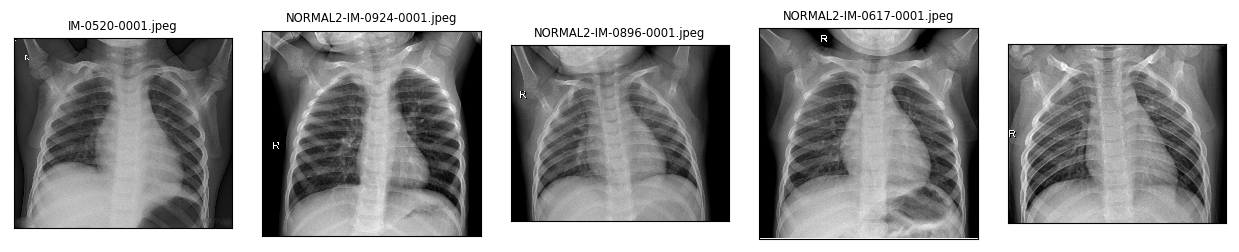


-------------------------------------------------------Pneumonia-------------------------------------------------------


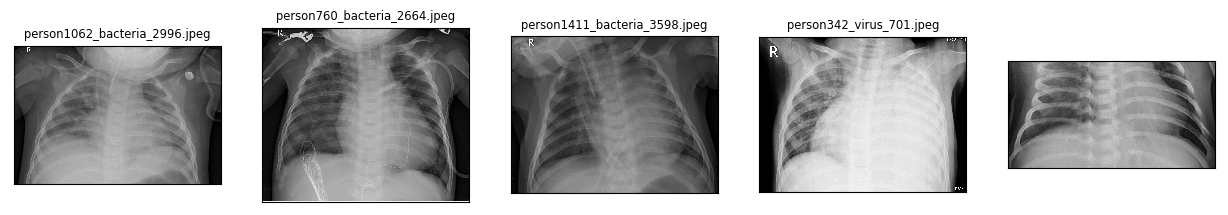


-------------------------------------------------------All Class Printed:2-------------------------------------------------------


In [12]:
show_class_sample_images(training_dir, image_count_per_category=5, save=False, dpi=100, update_image=False)

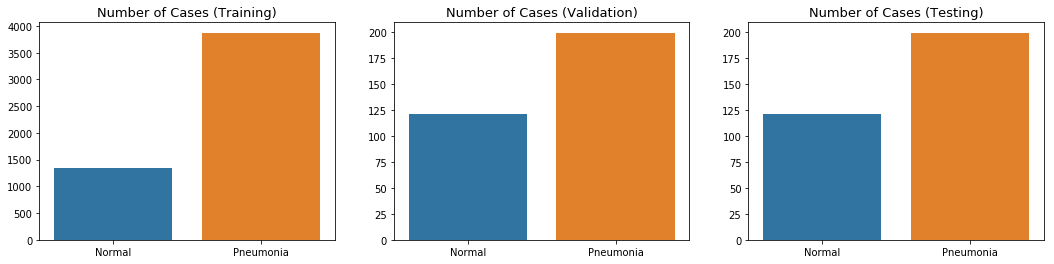

In [13]:
plot_params = get_reset_plot_params()

plot_params['figsize'] = (18,4)

plot_params['title_fontsize'] = 13
plot_params['label_fontsize'] = 10

plot_params['title'] = "Number of Cases"

plot_params['subplot'] = 131

show_train_val_test(training_dir, validation_dir, testing_dir, plot_params)
classes = os.listdir(training_dir)
classes = [name_correct(i) for i in classes]



### Image Preprocessing/ Augmentation/ Transformation for Training, Validation, Testing and  Dataset 

In [16]:
# batch_size = 32

# target_size = (299, 299)
# color_mode = "rgb"


rescale = 1./255
target_size = (150, 150)
batch_size = 32
class_mode = "categorical"
# class_mode = "binary"


train_datagen = ImageDataGenerator(
    rescale=rescale,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)


train_generator = train_datagen.flow_from_directory(
    training_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=batch_size,
    shuffle=True)


validation_datagen = ImageDataGenerator(rescale=rescale)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=len(os.listdir(validation_dir)),
    shuffle = False)


test_datagen = ImageDataGenerator(rescale=rescale)

test_generator = test_datagen.flow_from_directory(
    testing_dir,
    target_size=target_size,
    class_mode=class_mode,
    batch_size=len(os.listdir(testing_dir)),
    shuffle = False)

Found 5216 images belonging to 2 classes.
Found 320 images belonging to 2 classes.
Found 320 images belonging to 2 classes.


In [17]:
from sklearn.utils import class_weight
def get_weight(y):
    class_weight_current =  class_weight.compute_class_weight('balanced', np.unique(y), y)
    return class_weight_current

###  Training Files Configuration

In [18]:
class_weight = get_weight(train_generator.classes)
class_weight

array([1.9448173 , 0.67303226])

In [19]:
main_model_dir = output_directory + r"models/"
main_log_dir = output_directory + r"logs/"


clear_directory(main_log_dir)
remove_empty_folders(main_model_dir, False)


model_dir = main_model_dir + time.strftime('%Y-%m-%d %H-%M-%S') + "/"
log_dir = main_log_dir + time.strftime('%Y-%m-%d %H-%M-%S')

create_directory(model_dir, remove=True)
create_directory(log_dir, remove=True)

model_file = model_dir + "{epoch:02d}-val_acc-{val_acc:.2f}-val_loss-{val_loss:.2f}.hdf5"

### Callbacks 

In [20]:
reset_graph()
reset_callbacks()

In [21]:
print("Settting Callbacks at ", date_time(1))

checkpoint = ModelCheckpoint(
    model_file, 
    monitor='val_acc', 
    save_best_only=True)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True)


tensorboard = TensorBoard(
    log_dir=log_dir,
    batch_size=batch_size,
    update_freq = 'batch')


reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=5,
    cooldown=2,
    min_lr=0.0000000001,
    verbose=1)


#-----------------------------------------------------------------------------------------------------------------#
callbacks = [checkpoint, reduce_lr, early_stopping, tensorboard]
# callbacks = [checkpoint, tensorboard]
#-----------------------------------------------------------------------------------------------------------------#
print("Set Callbacks at ", date_time(1))

Settting Callbacks at  Timestamp: 2018-12-16 04:09:26
Set Callbacks at  Timestamp: 2018-12-16 04:09:48


In [22]:
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', padding="same", input_shape=(3,150,150)))
    model.add(Conv2D(16, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(3,150,150)))
    model.add(Conv2D(32, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
    model.add(Conv2D(64, (3, 3), padding="same", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(96, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
    model.add(Conv2D(96, (3, 3), padding="valid", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(128, (3, 3), dilation_rate=(2, 2), activation='relu', padding="same"))
    model.add(Conv2D(128, (3, 3), padding="valid", activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(2 , activation='softmax'))


    print(model.summary())
    
    return model

In [23]:
# Load and configure model InceptionV3 for fine-tuning with new class labels
def get_model():    
    
#     base_model = InceptionV3(weights=None, include_top=False)
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

    x = base_model.output
    
#     x = Dropout(0.5)(x)
    
#     x = GlobalAveragePooling2D()(x)
    
#     x = Dense(512, activation='relu')(x)
#     # x = Dense(1024, activation='relu')(x)
    
    x = BatchNormalization()(x)
    
# #     predictions = Dense(2, activation='sigmoid')(x) 
    predictions = Dense(2, activation='softmax')(x) 
    
    
    model = Model(inputs=base_model.input, outputs=predictions)
    
    
    for layer in base_model.layers:
        layer.trainable = False
        
        
#     for layer in model.layers[:249]:
#         layer.trainable = False
#     for layer in model.layers[249:]:
#         layer.trainable = True
        
    
    model.summary()
        
    return model

### Training/Fine-Tuning Base Model-InceptionV3 for Fine-Tuning with New Class Labels

In [24]:
print("Getting Base Model", date_time(1))
# model = get_model()
model = get_conv_model()
# model = keras.models.load_model("data/output/models/2018-12-15 00-26-45/13-val_acc-0.70-val_loss-0.58.hdf5")

Getting Base Model Timestamp: 2018-12-16 04:09:48
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 150, 150)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 150, 150)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 75, 75)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 75, 75)        4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 75, 75)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 32, 37, 37)        0         
_________________________________________________________________
conv2d_5 (Conv2D)         

In [25]:
print("Starting Trainning Model", date_time(1))


steps_per_epoch=len(train_generator)
validation_steps=len(validation_generator)



# lr = 0.00001
# optimizer=optimizers.Adam(lr=lr)



optimizer=optimizers.Adam()
loss='categorical_crossentropy'
metrics=['accuracy']
epochs = 100


model.compile(optimizer, loss=loss, metrics=metrics)

history = model.fit_generator(
    train_generator,
    steps_per_epoch = steps_per_epoch,
    epochs=epochs,
    verbose=2,
    callbacks=callbacks,
    validation_data=validation_generator,
    validation_steps=validation_steps, 
    class_weight=class_weight)

print("Completed Model Trainning", date_time(1))


Starting Trainning Model Timestamp: 2018-12-16 04:09:53
Epoch 1/100
 - 136s - loss: 0.5871 - acc: 0.7398 - val_loss: 0.6950 - val_acc: 0.6219
Epoch 2/100
 - 103s - loss: 0.4999 - acc: 0.7788 - val_loss: 0.8790 - val_acc: 0.6438
Epoch 3/100
 - 110s - loss: 0.4511 - acc: 0.8043 - val_loss: 0.7762 - val_acc: 0.6000
Epoch 4/100
 - 123s - loss: 0.3257 - acc: 0.8641 - val_loss: 0.3682 - val_acc: 0.8313
Epoch 5/100
 - 135s - loss: 0.2199 - acc: 0.9141 - val_loss: 0.5084 - val_acc: 0.8063
Epoch 6/100
 - 101s - loss: 0.1904 - acc: 0.9235 - val_loss: 0.3597 - val_acc: 0.8375
Epoch 7/100
 - 99s - loss: 0.1524 - acc: 0.9452 - val_loss: 0.2912 - val_acc: 0.8781
Epoch 8/100
 - 97s - loss: 0.1507 - acc: 0.9442 - val_loss: 0.2441 - val_acc: 0.8906
Epoch 9/100
 - 104s - loss: 0.1438 - acc: 0.9469 - val_loss: 0.2019 - val_acc: 0.9094
Epoch 10/100
 - 98s - loss: 0.1406 - acc: 0.9503 - val_loss: 0.6772 - val_acc: 0.8000
Epoch 11/100
 - 102s - loss: 0.1338 - acc: 0.9500 - val_loss: 0.3102 - val_acc: 0.8625

### Model Performance Visualization over the Epochs

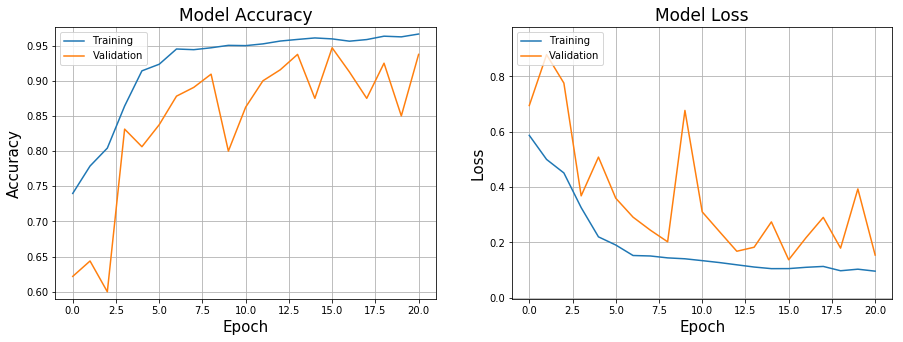

In [26]:
xlabel = 'Epoch'
legends = ['Training', 'Validation']

ylim_pad = [0.01, 0.1]


plt.figure(figsize=(15, 5))

# Plot training & validation Accuracy values

y1 = history.history['acc']
y2 = history.history['val_acc']

min_y = min(min(y1), min(y2))-ylim_pad[0]
max_y = max(max(y1), max(y2))+ylim_pad[0]


plt.subplot(121)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Accuracy', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()

                         
# Plot training & validation loss values
    
y1 = history.history['loss']
y2 = history.history['val_loss']

min_y = min(min(y1), min(y2))-ylim_pad[1]
max_y = max(max(y1), max(y2))+ylim_pad[1]
    
    
plt.subplot(122)

plt.plot(y1)
plt.plot(y2)

plt.title('Model Loss', fontsize=17)
plt.xlabel(xlabel, fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.ylim(min_y, max_y)
plt.legend(legends, loc='upper left')
plt.grid()
                         
plt.show()

### Test Saved Models

In [ ]:
dir_name = r"data/output/models/"
dirs = os.listdir(dir_name)
for i in range(len(dirs)):
    print(i, dirs[i])

In [ ]:
cur_dir =dir_name+dirs[9]+"/"
model_names = os.listdir(cur_dir)
for i in range(len(model_names)):
    print(i, model_names[i])

In [ ]:
model_file = cur_dir+model_names[5]

print(model_file)

In [ ]:
# cur_model = keras.models.load_model(model_file, custom_objects={'activation': swish_activation})

In [28]:
print("results")
result  = model.evaluate_generator(test_generator, steps=len(test_generator), verbose=2)

print("%s%.2f  "% ("Loss     : ", result[0]))
print("%s%.2f%s"% ("Accuracy : ", result[1]*100, "%"))

results
Loss     : 0.30  
Accuracy : 89.38%


In [32]:
print("results")
y_pred = model.predict_generator(test_generator, steps=len(test_generator), verbose=2)  
y_pred = y_pred.argmax(axis=-1)
y_true=test_generator.classes

results


Precision     : 86.26%
Recall        : 91.46%
F1-Score      : 88.78%


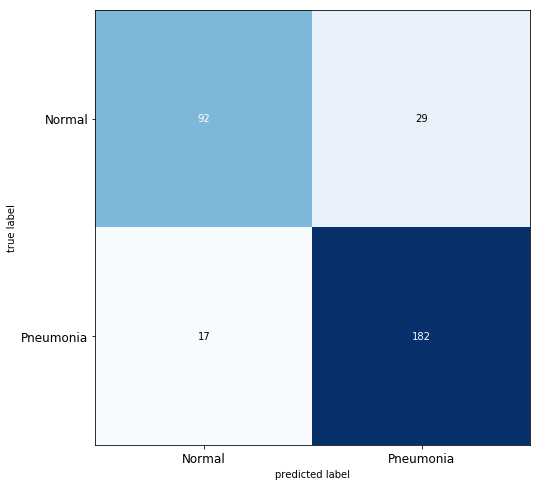

              precision    recall  f1-score   support

      Normal       0.84      0.76      0.80       121
   Pneumonia       0.86      0.91      0.89       199

   micro avg       0.86      0.86      0.86       320
   macro avg       0.85      0.84      0.84       320
weighted avg       0.86      0.86      0.85       320



In [33]:
precision = precision_score(y_true, y_pred) 
recall = recall_score(y_true, y_pred) 
f1 = f1_score(y_true, y_pred) 

print("%s%.2f%s"% ("Precision     : ", precision*100, "%"))
print("%s%.2f%s"% ("Recall        : ", recall*100,    "%"))
print("%s%.2f%s"% ("F1-Score      : ", f1*100,        "%"))


CM = confusion_matrix(y_true, y_pred)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(10,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(len(classes)), classes, fontsize=12)
plt.yticks(range(len(classes)), classes, fontsize=12)
plt.show()
    
cls_report_print = classification_report(y_true, y_pred, target_names=classes)

cls_report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)

print(cls_report_print)

In [34]:
numofbatch = len(test_generator)

batch_no = random.randint(0, numofbatch-1)

y_img_batch, y_true_batch = test_generator[batch_no] 
y_true_batch = y_true_batch.argmax(axis=-1)

y_pred_batch = model.predict(y_img_batch)
y_pred_batch = y_pred_batch.argmax(axis=-1)


sizeofbatch = len(y_true_batch)
print("-"*35)
print("%s%d"%     ("Selected Batch No       : ", batch_no))
print("-"*35)
print("%s%d"%     ("Batch Size              : ", len(y_pred_batch)))
print("-"*35)
print("%s%.2f%s"% ("Accuracy                : ", np.mean(y_true==y_pred)*100, "%"))
print("-"*35)

-----------------------------------
Selected Batch No       : 116
-----------------------------------
Batch Size              : 2
-----------------------------------
Accuracy                : 85.62%
-----------------------------------


### Visualization

In [ ]:
def show_predictions(y_img_batch, y_true, y_pred, subplot_params, plot_params, class_map, image_file_name, count=8, sample=True):
    fig, axs = get_fig_axs(subplot_params)
    plt.rcParams.update({'axes.titlesize': plot_params["axes.titlesize"]})
    plt.subplots_adjust(hspace=subplot_params["hspace"], wspace=subplot_params["wspace"])
    
    m = {}
    length = len(y_true)

    for i in range(0, count):  
        num = i
        if sample:
            num = random.randint(0, length-1)
            while num in m:
                num = int(random.randint(0, length-1))

            m[num]=1


        plt.subplot(subplot_params["nrows"], subplot_params["ncols"], i+1)
        plt.imshow(y_img_batch)

        plt.xticks([])
        plt.yticks([])
        
#         print(num, y_true[num], y_pred[num], title_text)
        
        original = class_map[y_true[num]]
        predicted = class_map[y_pred[num]]
        
        
        title_text = ("%s%s%s%s%s"%("True: ", original, "\n", "Pred", predicted))
        
        if original==predicted:
            plt.title(title_text)
        else:
            plt.title(title_text, color=false_prediction_label_color)
            

        if plot_params["update_image"] and os.path.exists(image_file_name):
            os.remove(image_file_name)   

        fig.savefig(image_file_name, dpi=plot_params["dpi"])

    plt.tight_layout()
    plt.show()



### Visualization

In [ ]:
image_file_name_batch = figure_directory+"/result"
image_file_name_sample = figure_directory+"/sample"

batch_size_t = len(y_true_batch)

ncols = 8

ncols = batch_size_t if batch_size_t<ncols else ncols     
nrows = batch_size_t/ncols

nrows = int(batch_size_t/ncols)+1 if batch_size_t%ncols else  int(batch_size_t/ncols)

dpi=100

subplot_params = get_reset_subplot_params(nrows, ncols, dpi)

plot_params = get_reset_plot_params()


class_map = {v: k for k, v in test_generator.class_indices.items()}

image_file_name = "sample"

#### Visualization 1 (Random Batch)
Visualization of performance of a random test dataset batch

In [ ]:
show_predictions(y_img_batch, y_true_batch, y_pred_batch, subplot_params, plot_params, class_map, image_file_name, sample=False)

#### Visualization 2 (Random) 
Visualization of performance of a few random images from a random batch

In [ ]:
cols = 4
rows = 2

if batch_size_t<4:
    cols = 1
    

count = cols*rows
    
figsize_col = cols*2.5
figsize_row = rows*2.5


figure_map["rows"]=rows
figure_map["cols"]=cols
figure_map["figsize_col"]=figsize_col
figure_map["figsize_row"]=figsize_row
figure_map["count"]=count 
figure_map["batch_size_tmp"]=batch_size_t 


show_predictions(y_img_batch, y_true_batch, y_pred_batch, image_file_name_batch, plt, figure_map)